<a href="https://colab.research.google.com/github/ClaudioB12/Fake-news-con-LSTM/blob/main/Detecci%C3%B3n_de_fake_news_con_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detección de Fake News usando LSTM Y Deep learning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [3]:
!pip install tensorflow==2.15.0

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

print("Todos los módulos se han importado correctamente.")


Todos los módulos se han importado correctamente.


# Exploración de fake news

In [5]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [8]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

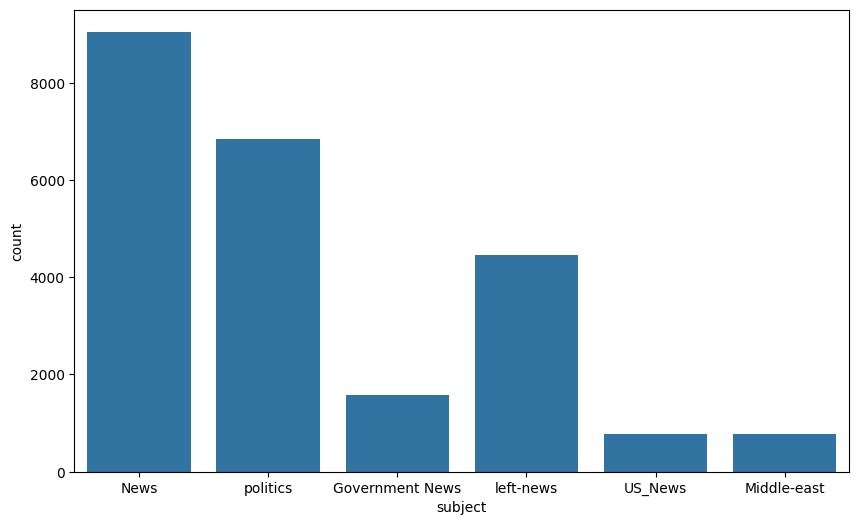

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'subject',data=fake)

**Wordcloud**


In [10]:
text = ' '.join(fake['text'].tolist())

In [11]:
' '.join(['this', 'is', 'a', 'data'])

'this is a data'

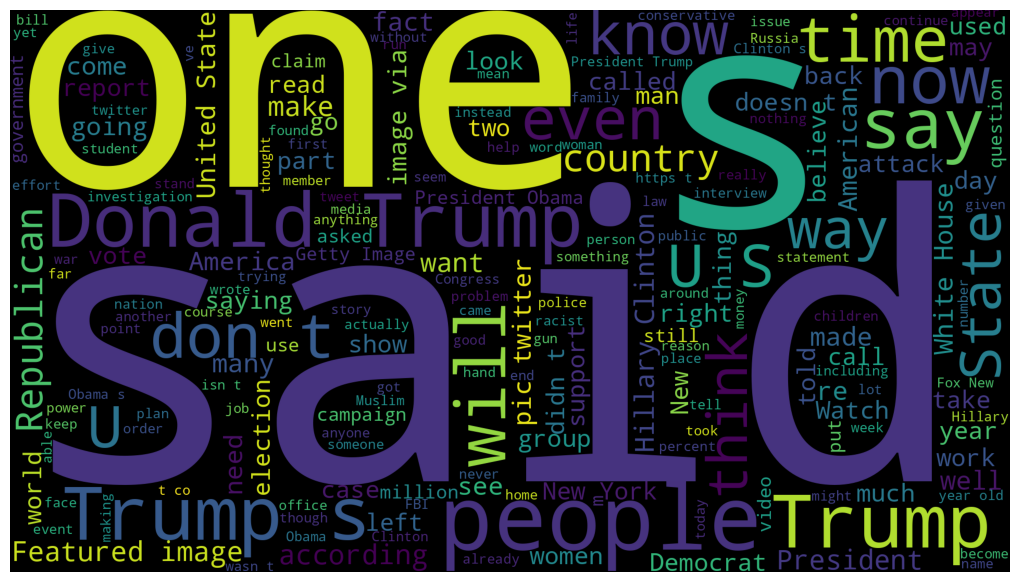

In [12]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Explorando con noticias reales

In [13]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [14]:
text = ' '.join(real['text'].tolist())

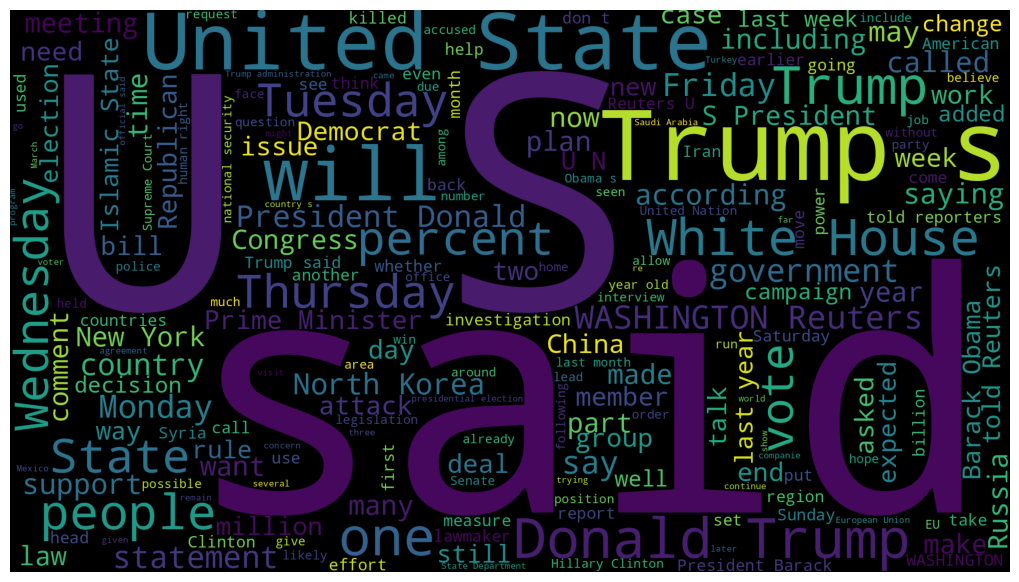

In [15]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [16]:
real.sample(5)

,title,text,subject,date
13708,"Turkey, United States 'on same wavelength', to...",ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,"November 28, 2017"
8953,Funding to combat Zika fails to advance in Senate,WASHINGTON (Reuters) - Funding to battle the Z...,politicsNews,"June 28, 2016"
15247,U.N. watchdog says Australia must change its m...,GENEVA (Reuters) - Australia should stop rejec...,worldnews,"November 9, 2017"
10047,How Ted Cruz win in Supreme Court hurt U.S.-Me...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"April 5, 2016"
18299,Russia says critically injures ex-Qaeda leader...,MOSCOW (Reuters) - Russia said on Wednesday it...,worldnews,"October 4, 2017"


In [45]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
      record = row.split('-', maxsplit=1)
      record[1]

      assert(len(record[0])<120)
    except:
      unknown_publishers.append(index)

In [46]:
len(unknown_publishers)

221

In [47]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [43]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [44]:
real = real.drop(8970, axis=0)

In [48]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())


In [50]:
real['publisher']=publisher
real['text'] = tmp_text

In [51]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [52]:
real.shape

(21416, 5)

In [55]:
empty_fake_index = [index for index,text in enumerate (fake.text.tolist()) if str(text).strip()==""]

In [56]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [58]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [59]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

# Preprocesamiento de texto

In [62]:
real['class'] = 1
fake['class'] = 0

In [61]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher'], dtype='object')

In [63]:
real = real[['text', 'class']]

In [64]:
fake = fake[['text', 'class']]

In [67]:
data = pd.concat([real, fake], ignore_index=True)

In [70]:
data.sample(5)

,text,class
12495,france expects slow but massive impact from la...,1
4021,exclusive: trump says u.s. wants fair treatmen...,1
24203,breaking: house dems have had it with trump a...,0
36627,not breaking…hillary likely lied: does obama’s...,0
26161,new poll leaves trump camp terrified as even ...,0


In [71]:
# https://github.com/laxmimerit/preprocess_kgptalkie

In [72]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-y7m349zn
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-y7m349zn
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=611a8ee00911b0c35d160bd849e821b25a29c86f14f8f7bdb486547efe597d6d
  Stored in di

In [73]:
import preprocess_kgptalkie as ps

In [74]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

0        as us budget fight looms republicans flip thei...
1        us military to accept transgender recruits on ...
2        senior us republican senator let mr mueller do...
3        fbi russia probe helped by australian diplomat...
4        trump wants postal service to charge much more...
                               ...                        
44892    mcpain john mccain furious that iran treated u...
44893    justice yahoo settles email privacy classactio...
44894    sunnistan us and allied safe zone plan to take...
44895    how to blow 700 million al jazeera america fin...
44896    10 us navy sailors held by iranian military si...
Name: text, Length: 44897, dtype: object

In [75]:
ps.remove_special_chars('this ,. @ # is gre@t')

'this is gret'

In [76]:
data.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [77]:
import gensim

In [79]:
y = data['class'].values

In [87]:
X = [d.split() for d in data['text'].tolist()]

In [88]:
type(X[0])

list

In [91]:
print(X[0])

['as', 'u.s.', 'budget', 'fight', 'looms,', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'u.s.', 'congress,', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts,', 'called', 'himself', 'a', '“fiscal', 'conservative”', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018.', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans,', 'u.s.', 'representative', 'mark', 'meadows,', 'speaking', 'on', 'cbs’', '“face', 'the', 'nation,”', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending,', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january.', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday,', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to

In [93]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [95]:
len(w2v_model.wv.key_to_index)

375437

In [96]:
w2v_model.wv.key_to_index

{'the': 0,
 'to': 1,
 'of': 2,
 'a': 3,
 'and': 4,
 'in': 5,
 'that': 6,
 'on': 7,
 'for': 8,
 's': 9,
 'is': 10,
 'he': 11,
 'with': 12,
 'was': 13,
 'it': 14,
 'trump': 15,
 'as': 16,
 'his': 17,
 'by': 18,
 'said': 19,
 'has': 20,
 'be': 21,
 'have': 22,
 'from': 23,
 'not': 24,
 'at': 25,
 'are': 26,
 'this': 27,
 'who': 28,
 'an': 29,
 'they': 30,
 'but': 31,
 'would': 32,
 'we': 33,
 'i': 34,
 'about': 35,
 'u.s.': 36,
 'will': 37,
 'their': 38,
 'president': 39,
 'had': 40,
 'been': 41,
 'you': 42,
 't': 43,
 'were': 44,
 'or': 45,
 'after': 46,
 'which': 47,
 'more': 48,
 'she': 49,
 'people': 50,
 'her': 51,
 'one': 52,
 'if': 53,
 'what': 54,
 'when': 55,
 'new': 56,
 'out': 57,
 'all': 58,
 'its': 59,
 'also': 60,
 'over': 61,
 'donald': 62,
 'state': 63,
 'no': 64,
 'up': 65,
 'our': 66,
 'there': 67,
 'can': 68,
 'said.': 69,
 'just': 70,
 'than': 71,
 'house': 72,
 'other': 73,
 'some': 74,
 'could': 75,
 'republican': 76,
 'obama': 77,
 'into': 78,
 'told': 79,
 'united'

In [98]:
w2v_model.wv['love']

array([-2.25200248e+00, -7.46015847e-01, -3.29877758e+00, -4.36531484e-01,
        3.83413851e-01,  9.41882491e-01, -1.27470285e-01, -2.76839185e+00,
       -7.24334383e+00, -1.53749660e-02, -3.76067376e+00,  4.32402547e-03,
        2.06156492e+00, -3.05691457e+00,  8.15924942e-01, -4.14835548e+00,
       -1.71512604e+00, -2.76852298e+00,  1.85100365e+00,  1.11294284e-01,
        2.72546458e+00,  4.24956465e+00,  5.91721609e-02,  1.84476626e+00,
        8.26775312e-01, -5.29091358e-01, -4.24659348e+00,  2.51737505e-01,
       -1.97008157e+00,  3.60727024e+00,  5.09334326e-01,  1.58363056e+00,
        6.92639887e-01, -1.39626610e+00, -2.86497688e+00,  6.75702572e-01,
       -2.92601204e+00, -3.72092104e+00,  6.35814726e-01, -1.68076038e+00,
        3.63578844e+00, -5.91165245e-01,  1.74753690e+00, -9.87172067e-01,
        1.76057518e-01,  1.45319676e+00, -1.46415520e+00, -2.73959017e+00,
       -1.57164288e+00, -2.77132797e+00,  8.00536990e-01, -1.11254349e-01,
        2.74143863e+00, -

In [104]:
w2v_model.wv.most_similar('peru')

[('colombia', 0.6544398665428162),
 ('argentina', 0.6485321521759033),
 ('colombian', 0.6431395411491394),
 ('pedro', 0.6402304172515869),
 ('chile', 0.6214365363121033),
 ('uruguay', 0.6188818216323853),
 ('pablo', 0.6180272102355957),
 ('portugal', 0.6135939359664917),
 ('dos', 0.6130601167678833),
 ('thailand', 0.606099009513855)]